In [88]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn import svm
import csv
import pandas as pd

In [89]:
data = pd.read_csv('labeled_data.csv', encoding = "ISO-8859-1", low_memory=False)
data.head(5)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [90]:


#Make 90% of data for training
#Original dataset said 0=Hate speech, 1=Offensive but not hate speech, 2=neither 
#We need binary labels so first we made +1 only if it is not hate speech (>0) but this made majority of the dataset +1 and very few -1. 
#So, changed labels so only classified as non-hate if orig label (>1)
training = open("training_data.txt", "w+")
for i in range(int(0.9*data.shape[0])):
  tweet = data["tweet"][i].replace("\n", " ")
  label = data["class"][i]
  if label > 1:
    label = "1"
  else:
    label = "0"
  
  training.write(label + " " + tweet + "\n")

training.close()

validation = open("validation_data.txt", "w+")
for i in range(1239):
  tweet = data["tweet"][22304+i].replace("\n", " ")

  label = data["class"][22304+i]
  if label > 1:
    label = "1"
  else:
    label = "0"
  
  validation.write(label + " " + tweet + "\n")

validation.close()

testing = open("testing_data.txt", "w+")
for i in range(1240):
  tweet = data["tweet"][23543+i].replace("\n", " ")

  label = data["class"][23543+i]
  if label > 1:
    label = "1"
  else:
    label = "0"
  
  testing.write(label + " " + tweet + "\n")

testing.close()



In [91]:
import nltk.corpus
nltk.download('stopwords')
from string import punctuation

training_tweets = []
training_labels = []
train = open("training_data.txt", "r")
train_lines = train.readlines()

#Clean data
train_lines = [line.strip() for line in train_lines]
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
for line in train_lines:
  tweet = line[2:]
 
  # remove punctuation from each token
  # table = str.maketrans('', '', punctuation)
  # tweet = [w.translate(table) for w in tweet]
  tweet = "".join([char for char in tweet if char not in punc])
 
  # remove remaining tokens that are not alphabetic
  tweet = "".join([word + " " for word in tweet.split() if word.isalpha()])
 
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tweet = "".join([w+" " for w in tweet.split() if not w in stop_words])
  training_tweets.append(tweet)
  training_labels.append(int(line[:1]))

#training_tweets = np.array(training_tweets)
training_labels = np.array(training_labels)

print(training_tweets[:5])
print(training_labels[:5])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['RT mayasolovely As woman shouldnt complain cleaning house amp man always take trash ', 'RT boy dats coldtyga dwn bad cuffin dat hoe place ', 'RT UrKindOfBrand Dawg RT You ever fuck bitch start cry You confused shit ', 'RT CGAnderson vivabased look like tranny ', 'RT ShenikaRoberts The shit hear might true might faker bitch told ya ']
[1 0 0 0 0]


In [92]:
validation_tweets = []
validation_labels = []
validation = open("validation_data.txt", "r")
validation_lines = validation.readlines()
validation_lines = [line.strip() for line in validation_lines]
for line in validation_lines:
  tweet = line[2:]
  # remove punctuation from each token
  tweet = "".join([char for char in tweet if char not in punc])
 
  # remove remaining tokens that are not alphabetic
  tweet = "".join([word + " " for word in tweet.split() if word.isalpha()])
 
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tweet = "".join([w+" " for w in tweet.split() if not w in stop_words])
  validation_tweets.append(tweet)
  validation_labels.append(int(line[:1])) #First indexs of line is label

#validation_tweets = np.array(validation_tweets)
validation_labels = np.array(validation_labels)

print(validation_tweets[:5])
print(validation_labels[:5])

['Twitter trash ', 'Twitter let know every hoe every city country ', 'Twitter niggas always want unprotected sex nothing ass bitches NAH ', 'Twitter pic flossin hoes talkin PapaWoodall fatstinker ', 'Twitter watching bitches ']
[1 0 0 0 0]


In [93]:
test_tweets = []
test_labels = []
test = open("testing_data.txt", "r")
test_lines = test.readlines()
test_lines = [line.strip() for line in test_lines]
for line in test_lines:
  tweet = line[2:]
  # remove punctuation from each token
  tweet = "".join([char for char in tweet if char not in punc])
 
  # remove remaining tokens that are not alphabetic
  tweet = "".join([word + " " for word in tweet.split() if word.isalpha()])
 
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tweet = "".join([w+" " for w in tweet.split() if not w in stop_words])
  test_tweets.append(tweet)
  test_labels.append(int(line[:1])) #First indexs of line is label

#validation_tweets = np.array(validation_tweets)
test_labels = np.array(test_labels)

print(test_tweets[:5])
print(test_labels[:5])

['aint bitch got shit ', 'aint nuttin ta cut bitch ', 'aint bitch Mimi still wit Gay ass Nikko ', 'aint trusting bitch nigga hoe sucka ', 'aint nuthin retarded bout Gucci gold rolex ']
[0 0 0 0 0]


In [94]:
import time
import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
#Random seed for reproducability

np.random.seed(42)


In [95]:
max_tweet_length = max([len(tweet) for tweet in training_tweets])
max_tweet_length2 = max([len(tweet) for tweet in validation_tweets])
max_tweet_length = max(max_tweet_length, max_tweet_length2)
print(max_tweet_length)

139


In [96]:
from keras.preprocessing.text import Tokenizer

#Create a vocabulary of word counts
word_counts = {}
for tweet in training_tweets:
  words = tweet.split()
  for word in words:
    if word not in word_counts:
      word_counts[word] = 1
    else:
      word_counts[word] += 1
  
for tweet in validation_tweets:
  words = tweet.split()
  for word in words:
    if word not in word_counts:
      word_counts[word] = 1
    else:
      word_counts[word] += 1

for tweet in test_tweets:
  words = tweet.split()
  for word in words:
    if word not in word_counts:
      word_counts[word] = 1
    else:
      word_counts[word] += 1
# removes low occur tokens
min_occur = 2
vocab = [k for k,c in word_counts.items() if c >= min_occur]

#print(len(vocab))

# filter out tokens not in vocab
cleaned_tweets = []
for tweet in training_tweets:
  words = tweet.split()
  tokens = [w for w in words if w in vocab]
  tokens = ' '.join(tokens)
  cleaned_tweets.append(tokens)
print(len(training_tweets))
print(len(cleaned_tweets))
cleaned_Val_tweets = []
for tweet in validation_tweets:
  words = tweet.split()
  tokens = [w for w in words if w in vocab]
  tokens = ' '.join(tokens)
  cleaned_Val_tweets.append(tokens)

cleaned_test_tweets = []
for tweet in test_tweets:
  words = tweet.split()
  tokens = [w for w in words if w in vocab]
  tokens = ' '.join(tokens)
  cleaned_test_tweets.append(tokens)

print(cleaned_tweets[:5])
print(cleaned_Val_tweets[:5])
print(cleaned_test_tweets[:5])
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(cleaned_tweets)
 
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(cleaned_tweets)
encoded_docs_Val = tokenizer.texts_to_sequences(cleaned_Val_tweets)
encoded_docs_test = tokenizer.texts_to_sequences(cleaned_test_tweets)


22304
22304
['RT As woman shouldnt complain cleaning house amp man always take trash', 'RT boy dats dwn bad cuffin dat hoe place', 'RT UrKindOfBrand Dawg RT You ever fuck bitch start cry You confused shit', 'RT vivabased look like tranny', 'RT The shit hear might true might faker bitch told ya']
['Twitter trash', 'Twitter let know every hoe every city country', 'Twitter niggas always want unprotected sex nothing ass bitches NAH', 'Twitter pic hoes talkin PapaWoodall', 'Twitter watching bitches']
['aint bitch got shit', 'aint nuttin ta cut bitch', 'aint bitch Mimi still wit Gay ass Nikko', 'aint trusting bitch nigga hoe sucka', 'aint nuthin retarded bout Gucci gold']


In [97]:
# pad sequences
max_length = max([len(s.split()) for s in cleaned_tweets])
Xtrain = sequence.pad_sequences(encoded_docs, maxlen=max_length)
Ytrain = training_labels

# sequence encode
Xval = sequence.pad_sequences(encoded_docs_Val, maxlen=max_length)
Yval = validation_labels

Xtest = sequence.pad_sequences(encoded_docs_test, maxlen=max_length)
Ytest = test_labels

vocab_size = len(tokenizer.word_index) + 1
#top_words = 10000

print(Xtrain[0])
print(Ytrain[0])
print(vocab_size)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    1
  523  307  918 1042 3414  233   21   41   93   85   19]
1
10559


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 25, 100)           1055900   
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 1,136,401
Trainable params: 1,136,401
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/6
349/349 [==============================] - 23s 59ms/step - loss: 0.3361 - accuracy: 0.8636 - val_loss: 0.1124 - val_accuracy: 0.9564
Epoch 2/6
349/349 [==============================] - 21s 59ms/step - loss: 0.0872 - accuracy: 0.9692 - val_loss: 0.1191 - val_accuracy: 0.9548
Epoch 3/6
349/349 [==============================] - 20s 59ms/step - loss: 0.0467 

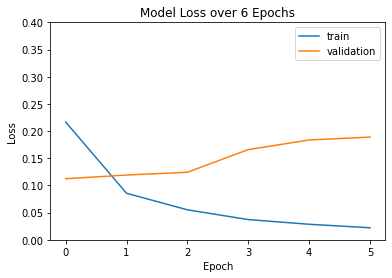

In [98]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
#model.add(Dropout(0.2))
model.add(LSTM(100))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=6, batch_size=64)

predictions = model.predict(Xval)
i = 0
for prediction in predictions:
  prediction = predictions[i]
  if prediction < 0.5:
    prediction = 0
  else:
    prediction = 1
  if prediction != Yval[i]:
    print(cleaned_Val_tweets[i], prediction, Yval[i])
  i += 1
print(predictions[:10])

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss over 6 Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 0.4)
plt.legend(["train", "validation"])
scores = model.evaluate(Xtest, Ytest, verbose=0)
print("Test Data Accuracy: %.2f%%" % (scores[1]*100))

In [99]:
print(scores)

[0.23294158279895782, 0.9370967745780945]


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 25, 100)           1055900   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21, 128)           64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                12810     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 1,132,849
Trainable params: 1,132,849
Non-trainable params: 0
___________________________________________

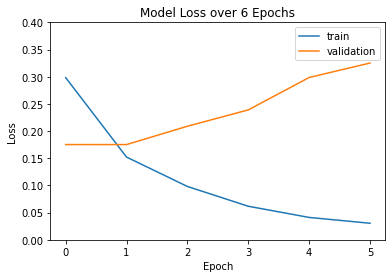

In [100]:
#cnn code
model2 = Sequential()
model2.add(Embedding(vocab_size, 100, input_length=max_length))
model2.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(10, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
print(model2.summary())
# compile network
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model2.fit(Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=6, batch_size=64, verbose=2)
predictions = model2.predict(Xval)
i = 0
for prediction in predictions:
  prediction = predictions[i]
  if prediction < 0.5:
    prediction = 0
  else:
    prediction = 1
  if prediction != Yval[i]:
    print(cleaned_Val_tweets[i], prediction, Yval[i])
  i += 1
print(predictions[:10])

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss over 6 Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 0.4)
plt.legend(["train", "validation"])
# evaluate
loss, acc = model2.evaluate(Xtest, Ytest, verbose=0)
print('Test Data Accuracy: %f' % (acc*100))